In [99]:
def sub(point_1, point_2):
    """
    Returns point_2 - point_1
    """
    return [x - y for x, y in zip(point_1, point_2)]

def add(point_1, point_2):
    """
    Returns point_2 + point_1
    """
    return [x + y for x, y in zip(point_1, point_2)]

def unit_bisector(point_1, point_2, point_3):
    vec = sub(point_1, point_2)
    angle_a = math.atan2(vec[1], vec[0])
    vec = sub(point_3, point_2)
    angle_b = math.atan2(vec[1], vec[0])

    bisector = (angle_a + angle_b) / 2

    return math.cos(bisector), math.sin(bisector)

def dot(point_1, point_2):
    return sum([x * y for x, y in zip(point_1, point_2)])

def mul(scalar, vec):
    return [scalar * x for x in vec]

def dista(vec):
    return (vec[0] ** 2 + vec[1] ** 2) ** .5
    

In [155]:
def distance_point_to_line(p1, p2, p3):
    """
    Calculate the shortest distance between a point (p3) and a line formed by points (p1, p2).
    :param p1: First point on the line (x1, y1)
    :param p2: Second point on the line (x2, y2)
    :param p3: Point for which distance is to be calculated (x3, y3)
    :return: Shortest distance between the point and the line
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3

    # Calculate the components of the line segment
    dx = x2 - x1
    dy = y2 - y1

    # If the line is just a point
    if dx == dy == 0:
        return math.sqrt((x3 - x1)**2 + (y3 - y1)**2)

    # Calculate the projection of the point onto the line
    u = ((x3 - x1) * dx + (y3 - y1) * dy) / (dx**2 + dy**2)
    x_proj = x1 + u * dx
    y_proj = y1 + u * dy

    # Calculate the distance between the projected point and the given point
    distance = math.sqrt((x3 - x_proj)**2 + (y3 - y_proj)**2)
    return distance

In [156]:
def check_obstacle(waypoints, obstacles):
    for obstacle in obstacles:
        obs_dist = obstacle[2] ** 2
        
        for i in range(len(waypoints[0])):
            dist = (obstacle[0] - waypoints[0][i]) ** 2 + (obstacle[1] - waypoints[1][i]) ** 2 - obs_dist

            if dist < 0:
                return True

    return False

In [157]:
import numpy as np

def quadratic_bezier_curve(P0, P1, P2, t):
    """
    Generate a point on a quadratic Bezier curve.

    Parameters:
        P0: Starting point (tuple or list) - (x0, y0)
        P1: Control point (tuple or list) - (x1, y1)
        P2: Ending point (tuple or list) - (x2, y2)
        t: Parameter value ranging from 0 to 1

    Returns:
        Point on the Bezier curve corresponding to the given parameter t (tuple) - (x, y)
    """
    # Calculate the point on the curve using the quadratic Bezier curve equation
    x = (1 - t) ** 2 * P0[0] + 2 * (1 - t) * t * P1[0] + t ** 2 * P2[0]
    y = (1 - t) ** 2 * P0[1] + 2 * (1 - t) * t * P1[1] + t ** 2 * P2[1]
    return x, y

def bezier_points(P0, P1, P2, num_waypoints):
    points = [quadratic_bezier_curve(P0, P1, P2, t) for t in np.linspace(0, 1, num_waypoints)]
    
    ex_x = [x[0] for x in points]
    ex_y = [x[1] for x in points]

    return ex_x, ex_y

In [158]:
import math

def gen_waypoint_trace(prev_waypoint, curr_waypoint, next_waypoint, trace):
    """
    Generates two waypoints: one trace distance back towards the previous waypoint, one trace distance forward towards the next.
    """
    vec_back = sub(curr_waypoint, prev_waypoint)
    angle = math.atan2(vec_back[1], vec_back[0])

    x_back = sub(curr_waypoint, [trace * math.cos(angle), trace * math.sin(angle)])

    vec_forw = sub(curr_waypoint, next_waypoint)
    angle = math.atan2(vec_forw[1], vec_forw[0])

    x_forw = sub(curr_waypoint, [trace * math.cos(angle), trace * math.sin(angle)])

    return x_back, curr_waypoint, x_forw

In [159]:
def optimize(waypoint_prev, waypoint, waypoint_next, backtrace, max_scale, obstacles, iters):
    # TODO: Make it so this optimizes on the normal distance of middle point instead of backtrace distance
    bisector = unit_bisector(waypoint_prev, waypoint, waypoint_next)

    max_scale = distance_point_to_line(waypoint_prev, waypoint_next, waypoint) / 2
    print("MAX_SCALE: ", max_scale)
    
    scale = 0
    
    delta = 2
    lr = .9

    best = []
    best_scale = scale

    for i in range(iters):
        extra = gen_waypoint_trace(waypoint_prev, sub(waypoint, [-scale * bisector[0], -scale * bisector[1]]), waypoint_next, backtrace)
        gen_points = bezier_points(extra[0], extra[1], extra[2], 25)
    
        if check_obstacle(gen_points, obstacles):
            print("COLLISION")
            scale -= delta
            delta *= lr
        else:
            if scale == max_scale:
                best = gen_points
                best_scale = scale
                break
            
            print("ADVANCE: NEW BACKTRACE: ", scale + delta)
            if backtrace > best_scale:
                best = gen_points
                best_scale = scale
                
            scale += delta
            scale = min(max_scale, scale)

    return best, (bisector[0] * scale, bisector[1] * scale)
            
    

In [160]:
waypoints = [(5, 5), (55, 55), (376, 38), (477, 219), (404, 336), (357, 356), (340, 340)]
waypoints_x = [x[0] for x in waypoints]
waypoints_y = [x[1] for x in waypoints]

obstacles = [(60, 25, 15), (370, 55, 10)]

backtrace_distance = 20  # Distance to backtrace to generate a new waypoint for bezier curve
extra = []

def dist(waypoint_a, waypoint_b):
    return ((waypoint_a[0] - waypoint_b[0]) ** 2 + (waypoint_a[1] - waypoint_b[1]) ** 2) ** .5

unit_vecs = []

for i in range(len(waypoints)-2):
    # print(min(dist(waypoints[i], waypoints[i+1]), dist(waypoints[i+1], waypoints[i+2])) / 4)
    best, unit_vec = optimize(waypoints[i], waypoints[i+1], waypoints[i+2], backtrace_distance, 15, obstacles, 100)
    # extra.append(gen_waypoint_trace(waypoints[i], waypoints[i+1], waypoints[i+2], backtrace_distance))
    # print(best)
    # print("BEST: ", best_backtrace)
    unit_vecs.append((waypoints[i+1], unit_vec))
    extra.append(best)

gen_points = []

for i in extra:
    gen_points.append(i)
    # gen_points.append(bezier_points(i[0], i[1], i[2], 25))

MAX_SCALE:  22.686709803344034
ADVANCE: NEW BACKTRACE:  2
ADVANCE: NEW BACKTRACE:  4
ADVANCE: NEW BACKTRACE:  6
ADVANCE: NEW BACKTRACE:  8
ADVANCE: NEW BACKTRACE:  10
ADVANCE: NEW BACKTRACE:  12
COLLISION
ADVANCE: NEW BACKTRACE:  11.8
COLLISION
ADVANCE: NEW BACKTRACE:  11.620000000000001
ADVANCE: NEW BACKTRACE:  13.240000000000002
COLLISION
ADVANCE: NEW BACKTRACE:  13.078000000000001
COLLISION
ADVANCE: NEW BACKTRACE:  12.932200000000002
COLLISION
ADVANCE: NEW BACKTRACE:  12.800980000000001
COLLISION
ADVANCE: NEW BACKTRACE:  12.682882000000001
COLLISION
ADVANCE: NEW BACKTRACE:  12.576593800000001
COLLISION
ADVANCE: NEW BACKTRACE:  12.48093442
COLLISION
ADVANCE: NEW BACKTRACE:  12.394840978000001
COLLISION
ADVANCE: NEW BACKTRACE:  12.317356880200002
COLLISION
ADVANCE: NEW BACKTRACE:  12.247621192180002
COLLISION
ADVANCE: NEW BACKTRACE:  12.184859072962002
COLLISION
ADVANCE: NEW BACKTRACE:  12.128373165665801
COLLISION
ADVANCE: NEW BACKTRACE:  12.07753584909922
COLLISION
ADVANCE: NEW BACK

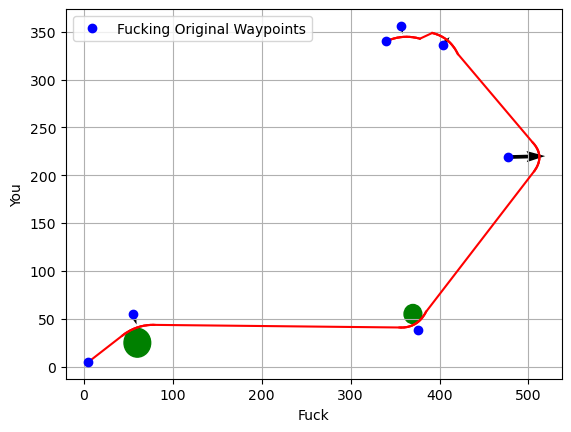

In [161]:
import matplotlib.pyplot as plt

# Plot points with different colors
# plt.plot([waypoints_x[0], beziers_x[0]], [waypoints_y[0], beziers_y[0]], marker='o', linestyle='-')

prev_x = waypoints_x[0]
prev_y = waypoints_y[0]

for i in gen_points:
    bez_x = i[0]
    bez_y = i[1]

    for i in range(len(bez_x)):
        plt.plot([prev_x, bez_x[i]], [prev_y, bez_y[i]], color='red', linestyle='-')
        prev_x = bez_x[i]
        prev_y = bez_y[i]

plt.plot([prev_x, waypoints_x[-1]], [prev_y, waypoints_y[-1]], color='red', linestyle='-')

for i in unit_vecs:
    plt.quiver(i[0][0], i[0][1], i[1][0], i[1][1], angles='xy', scale_units='xy', scale=1)

for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='g')
    plt.gca().add_patch(circle)
    
plt.plot(waypoints_x, waypoints_y, 'bo', label='Fucking Original Waypoints')  # 'bo' specifies blue circles
plt.xlabel('Fuck')
plt.ylabel('You')
plt.grid(True)  # Add grid
plt.legend()  # Add legend
plt.show()